# Train Unet on FMD dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

from util import show, plot_images, plot_tensors
from data_loader_FMD import pil_loader, load_denoising

In [3]:
import torch

Load the FMD dataset

In [4]:
root = '/home/yina/DeepDenoising/Data/FMD/'
loader = pil_loader
train = True
noise_levels = [1, 2, 4, 8, 16]
types = None
captures = 20
patch_size = 128
batch_size = 32
transform = None
target_transform = None
test_fov = 19

kwargs = {'drop_last': False}
add_kwargs = {'num_workers': 4, 'pin_memory': True} \
    if torch.cuda.is_available() else {}
kwargs.update(add_kwargs)

In [5]:
loader = load_denoising(root, train, batch_size, noise_levels=noise_levels,
    types=types, captures=captures, patch_size=patch_size, transform=transform, 
    target_transform=target_transform, loader=pil_loader, test_fov=test_fov)

{
    "Dataset": "train",
    "Noise levels": [
        1,
        2,
        4,
        8,
        16
    ],
    "12 Types": [
        "TwoPhoton_BPAE_R",
        "TwoPhoton_BPAE_G",
        "TwoPhoton_BPAE_B",
        "TwoPhoton_MICE",
        "Confocal_MICE",
        "Confocal_BPAE_R",
        "Confocal_BPAE_G",
        "Confocal_BPAE_B",
        "Confocal_FISH",
        "WideField_BPAE_R",
        "WideField_BPAE_G",
        "WideField_BPAE_B"
    ],
    "Fovs": [
        1,
        2,
        3,
        4,
        5,
        6,
        7,
        8,
        9,
        10,
        11,
        12,
        13,
        14,
        15,
        16,
        17,
        18,
        20
    ],
    "# samples": 22800
}


0 torch.Size([32, 1, 128, 128])
0 torch.Size([32, 1, 128, 128])


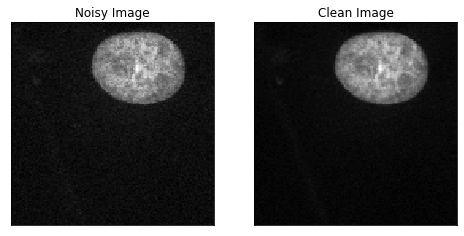

In [6]:
for i_batch, (noisy, clean) in enumerate(loader):
    print(i_batch, noisy.shape)
    print(i_batch, clean.shape)
    plot_tensors([noisy[0,0,:], clean[0,0,:]], ['Noisy Image', 'Clean Image'])
    break

# Model

In [7]:
from models.unet import Unet
model = Unet(up='nearest')

# Training

In [8]:
from util import getbestgpu
device = getbestgpu(1)

GPU device 0 has 3083 MiB left.
--> GPU device 0 was chosen


In [9]:
model = model.to(device)

In [10]:
from torch.nn import MSELoss
from torch.optim import Adam

loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)
n_epoch = 50

In [11]:
for epoch in range(n_epoch):

    running_loss = 0.0
    
    for i, (noisy, clean) in enumerate(loader):
        noisy_images, clean_images = noisy.type(torch.FloatTensor).to(device), clean.type(torch.FloatTensor).to(device)
        
        optimizer.zero_grad()
    
        net_output = model(noisy_images)
        loss = loss_function(net_output, clean_images)
 
        loss.backward()
    
        optimizer.step()
    
         # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 200))
            print(net_output.shape)
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 0.01042
torch.Size([32, 1, 128, 128])
[1,   400] loss: 0.00043
torch.Size([32, 1, 128, 128])
[1,   600] loss: 0.00036
torch.Size([32, 1, 128, 128])
[2,   200] loss: 0.00034
torch.Size([32, 1, 128, 128])
[2,   400] loss: 0.00031
torch.Size([32, 1, 128, 128])
[2,   600] loss: 0.00032
torch.Size([32, 1, 128, 128])
[3,   200] loss: 0.00030
torch.Size([32, 1, 128, 128])
[3,   400] loss: 0.00029
torch.Size([32, 1, 128, 128])
[3,   600] loss: 0.00028
torch.Size([32, 1, 128, 128])
[4,   200] loss: 0.00028
torch.Size([32, 1, 128, 128])
[4,   400] loss: 0.00027
torch.Size([32, 1, 128, 128])
[4,   600] loss: 0.00026
torch.Size([32, 1, 128, 128])
[5,   200] loss: 0.00026
torch.Size([32, 1, 128, 128])
[5,   400] loss: 0.00023
torch.Size([32, 1, 128, 128])
[5,   600] loss: 0.00026
torch.Size([32, 1, 128, 128])
[6,   200] loss: 0.00024
torch.Size([32, 1, 128, 128])
[6,   400] loss: 0.00022
torch.Size([32, 1, 128, 128])
[6,   600] loss: 0.00024
torch.Size([32, 1, 128, 128])
[7,   200]

[50,   200] loss: 0.00006
torch.Size([32, 1, 128, 128])
[50,   400] loss: 0.00006
torch.Size([32, 1, 128, 128])
[50,   600] loss: 0.00007
torch.Size([32, 1, 128, 128])
Finished Training


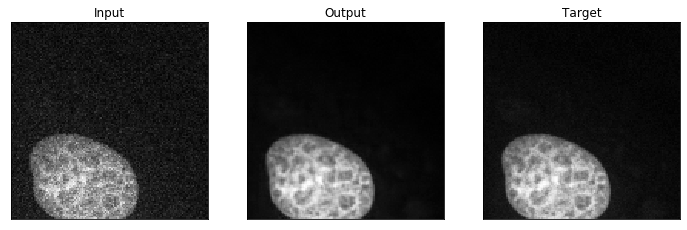

In [12]:
plot_tensors([noisy_images[0,0,:], net_output[0,0,:], clean_images[0,0,:]], ['Input','Output','Target'])

In [13]:
torch.save(model.state_dict(), './models/FMD_epoch50_model_nearestup')